#### Script to create time series of various variables from WRF output after applying conditional averaging / weighted averaging.

James Ruppert  
jruppert@ou.edu  
6/23/23

#### Main Settings

In [1]:
from netCDF4 import Dataset
import numpy as np
import matplotlib
# matplotlib.use('pdf')
import matplotlib.pyplot as plt
import sys
# from mask_tc_track import mask_tc_track
import pandas as pd
from precip_class import *
from read_functions import *
# from cfads_functions import *
from scipy import stats
import pickle

In [2]:
# #### Main settings

# Write out pickle files?
do_write=True
# do_write=False

# NOTE: Using copied tracking from CTL for NCRF tests

storm = 'haiyan'
# storm = 'maria'

# How many members
nmem = 10 # number of ensemble members
# nmem = 2

# #### Directories

figdir = "/home/jamesrup/figures/tc/ens/time_series/"
main = "/ourdisk/hpc/radclouds/auto_archive_notyet/tape_2copies/tc_ens/"
main_pickle = "/ourdisk/hpc/radclouds/auto_archive_notyet/tape_2copies/jruppert/tc_postproc/"+storm+'/'

In [3]:
# #### Variable selection

var_names = [
    'strat',    # NEED THIS
    'vmfu',     # NEED THIS
    'vmfd',     # NEED THIS
    'vmf',
    # 'pw',
    'mse_vint',
    'vadv_mse_vint',
    'mse_diverg_vint',
    'mse_fluxdiverg_vint',
    'satfrac',
    'condh',
    'rain',
    ]

# Tests to read and compare
if storm == 'haiyan':
    # tests = ['ctl','ncrf36h']
    tests = ['ctl','ncrf36h','STRATANVIL_ON','STRATANVIL_OFF','STRAT_OFF']
    tests_str = ['CTL','NCRF','CONVOFF','STRATANVOFF','STRATOFF']
elif storm == 'maria':
#        tests = ['ctl','ncrf36h']
    tests = ['ctl','ncrf48h']
ntest=len(tests)

In [4]:
# Prep tests & ens members

def get_tshift(itest):
    if itest == 'ctl':
        tshift=0
    elif itest == 'ncrf36h':
        tshift=36
    elif 'STRAT' in itest:
        tshift=36
    elif itest == 'ncrf48h':
        tshift=48
    return tshift

# Ens member strings
memb0=1 # Starting member to read
nums=np.arange(memb0,nmem+memb0,1)
nums=nums.astype(str)
nustr = np.char.zfill(nums, 2)
memb_all=np.char.add('memb_',nustr)

nt = np.zeros(ntest, dtype=np.int32)
for itest in range(ntest):
    ##### Get dimensions
    datdir = main+storm+'/'+memb_all[0]+'/'+tests[itest]+'/'
    varfil_main = Dataset(datdir+'post/d02/T.nc')
    i_nt = varfil_main.dimensions['time'].size
    varfil_main.close()
    nt[itest]=i_nt

---
#### Functions for reading and processing

In [25]:
# Function to read all variables

def nc_var_read(filename, varname):
    varfil_main = Dataset(filename)
    var = varfil_main.variables[varname][...]
    varfil_main.close()
    return var

def tidy_up(var):
    var = np.squeeze(var)
    var = np.ma.masked_invalid(var, copy=False)
    var = mask_edges(var)
    # Can swap in masking by TC track here
    var = np.ma.filled(var, fill_value=np.nan) # Abandon masking, replace mask with NaNs
    return var

def read_all_vars(var_names):

    var_list = []
    for var_name in var_names:
        diagfile = datdir+'mse_diag.nc'
        if var_name == 'strat':
        # New classification scheme
            q_int = nc_var_read(datdir+'q_int.nc', 'q_int')
            var = precip_class(q_int).astype(np.float16)
        elif var_name == 'vmfu':
        # Vertical mass flux
            var = nc_var_read(diagfile, var_name) # kg/m/s
        elif var_name == 'vmfd':
            var = nc_var_read(diagfile, var_name) # kg/m/s
        elif var_name == 'pw':
            var = nc_var_read(diagfile, var_name) # mm
        elif var_name == 'mse_vint':
            var = nc_var_read(diagfile, var_name) # J/m2
        elif var_name == 'vadv_mse_vint':
            var = nc_var_read(diagfile, var_name) # J/m^2/s
            # var *= -1 # switch to Eulerian
            # VADV function in write_diagnostics already in EULERIAN
        elif var_name == 'mse_diverg_vint':
            var = nc_var_read(diagfile, var_name) # J/m^2/s
            var *= -1 # switch to Eulerian
        elif var_name == 'mse_fluxdiverg_vint':
            var = nc_var_read(diagfile, var_name) # J/m^2/s
            var *= -1 # switch to Eulerian
        elif var_name == 'satfrac':
            ipw = nc_var_read(diagfile, 'pw') # mm
            ipw_sat = nc_var_read(diagfile, 'pw_sat') # mm
            var = ipw/ipw_sat # %
        elif var_name == 'condh':
            var = nc_var_read(diagfile, var_name) # mm/d
            var /= 24 # mm/d --> mm/hr
        else:
            raise ValueError("Something wrong in variable read specifics")
        
        var = tidy_up(var)
        var_list.append(var)

    return var_list

In [26]:
# Function to do conditional averaging (and weighting)

def get_condavg_settings():
    
    condavg_label = [
        'all',      # All unmasked points
        # 'non-precip',
        'deep',
        # 'cong',
        # 'shall',
        # 'strat',
        # 'anvil',
        'deepcong', # deep + cong
        'stratanv', # strat + anv
        'allrain',  # deep + cong + strat + anv
        'upward',   # upward-motion-weighted
        'downward', # downward-motion-weighted
        ]

    condavg_title = [
        'All',
        # 'Non Precip',
        'Dc',
        # 'Cg',
        # 'Sh',
        # 'St',
        # 'An',
        'Dc+Cg',
        'St+An',  
        'Dp+Cg+St+An',
        'Upward',
        'Downward',
        ]

    return condavg_label, condavg_title

condavg_label, condavg_title = get_condavg_settings()
ncond = len(condavg_label)


def conditional_avg(strat, var_stack):

    condavg_label, condavg_title = get_condavg_settings()
    ncond = len(condavg_label)
    nvar = var_stack.shape[0]
    nt = np.shape(strat)[0]

    vmfu = var_stack[0]
    vmfd = var_stack[1]

    # var_avg = np.ma.zeros((ncond, nvar, nt))
    var_avg = np.zeros((ncond, nvar, nt))

    # Internal functions
    def weighted_avg(var_stack, weights):
        num   = np.nansum(var_stack * weights, axis=(2,3))
        denom = np.nansum(weights,             axis=(2,3))
        return num/denom

    # Masks *OUT* according to the below conditions
    # Averages conditionally based on selected strat indices

    # Extend strat along a new dimension representing all variables to avoid loops in this task
    strat_extend = np.repeat(strat[np.newaxis, ...], nvar, axis=0)

    kcond=0
    # all = simple average over whole domain
    var_avg[kcond, ...] = np.nanmean(var_stack, axis=(2,3))

    kcond+=1
    # deep
    condition = (strat_extend == 1)
    var_avg[kcond, ...] = np.nanmean(var_stack, axis=(2,3), where=condition)

    kcond+=1
    # deep + cong
    condition = ((strat_extend == 1) | (strat_extend == 2))
    var_avg[kcond, ...] = np.nanmean(var_stack, axis=(2,3), where=condition)

    kcond+=1
    # strat + anv
    condition = ((strat_extend == 4) | (strat_extend == 5))
    var_avg[kcond, ...] = np.nanmean(var_stack, axis=(2,3), where=condition)

    kcond+=1
    # allrain: deep + cong + strat + anv
    condition = ((strat_extend == 1) | (strat_extend == 2) | (strat_extend == 4) | (strat_extend == 5))
    var_avg[kcond, ...] = np.nanmean(var_stack, axis=(2,3), where=condition)

    # Weighting function

    kcond+=1
    # upward-weighted
    vmfu_extend = np.repeat(vmfu[np.newaxis, ...], nvar, axis=0)
    var_avg[kcond, ...] = weighted_avg(var_stack, weights=vmfu_extend)

    kcond+=1
    # downward-weighted
    vmfd_extend = np.repeat(vmfd[np.newaxis, ...], nvar, axis=0)
    var_avg[kcond, ...] = weighted_avg(var_stack, weights=vmfd_extend)

    return var_avg

---
#### Main work starts below this point:

#### Loops over tests and ensemble members, reads and processes variables via the functions above.

In [27]:
# Create arrays

# Time index set based on TEST 0 (e.g., CTL)

nvar = len(var_names)
# var_sav = np.ma.masked_all((ntest,nmem,ncond,nvar-1,nt[0]))
shape = (ntest,nmem,ncond,nvar-1,nt[0])
var_sav = np.full(shape, np.nan, dtype=np.float64)

#### Main loops

for itest in range(ntest):
# for itest in range(1):

    print()
    print('Running test: ',tests[itest])
    print()

    if do_write:

        for imemb in range(nmem):
        # for imemb in range(1):

            print('Running imemb: ',memb_all[imemb])
            datdir = main+storm+'/'+memb_all[imemb]+'/'+tests[itest]+'/post/d02/'
            
            # Read all vars into a list
            var_list = read_all_vars(var_names)

            # Combine vars using np.stack, keeping strat separate (only using it for conditional averaging)
            strat = var_list[0]
            # var_stack = np.ma.stack(var_list[1:], axis=0)
            var_stack = np.stack(var_list[1:], axis=0)

            # Conduct conditional averaging / weighted averaging
            var_avg = conditional_avg(strat, var_stack)

            # Save averaged results

            t0=0
            t1=nt[itest]
            tshift = get_tshift(tests[itest])
            # times_itest = np.arange(tshift, nt[itest]+tshift, 1)

            var_sav[itest, imemb, ..., tshift:nt[itest]+tshift] = var_avg

            pickle_file = main_pickle+memb_all[imemb]+'/mean_profiles_'+str(t1_test)+'hrs.pkl'
            with open(pickle_file, 'wb') as file:
                pickle.dump([w_mean, rho_mean, qv_mean, tmpk_mean,
                            lw_mean, lwc_mean, sw_mean, swc_mean], file)
            # else:
            #     with open(pickle_file, 'rb') as file:
            #         w_mean,qv_mean,tmpk_mean = pickle.load(file)

    else:



Running test:  ctl

Running imemb:  memb_01


/scratch/jamesrup/tmp/ipykernel_20100/244809141.py:73: RuntimeWarning: Mean of empty slice
  var_avg[kcond, ...] = np.nanmean(var_stack, axis=(2,3), where=condition)
/scratch/jamesrup/tmp/ipykernel_20100/244809141.py:78: RuntimeWarning: Mean of empty slice
  var_avg[kcond, ...] = np.nanmean(var_stack, axis=(2,3), where=condition)
/scratch/jamesrup/tmp/ipykernel_20100/244809141.py:83: RuntimeWarning: Mean of empty slice
  var_avg[kcond, ...] = np.nanmean(var_stack, axis=(2,3), where=condition)
/scratch/jamesrup/tmp/ipykernel_20100/244809141.py:88: RuntimeWarning: Mean of empty slice
  var_avg[kcond, ...] = np.nanmean(var_stack, axis=(2,3), where=condition)


Running imemb:  memb_02

Running test:  ncrf36h

Running imemb:  memb_01
Running imemb:  memb_02


---
#### New variables

In [29]:
# var_names_plot = var_names[1:]
# var_names_plot[0]='mf_ratio' # downward / upward mf ratio
# var_names_plot[1]='pe_mf' # precip effic = 1 - mf_ratio
var_names_plot = [
    'mf_ratio', # downward / upward mf ratio
    'pe_mf',    # precip effic = 1 - mf_ratio
    ]

var_sav_plot = np.ma.copy(var_sav)

# Vertical mass flux ratio (overwrites vmfu)
var_sav_plot[..., 0, :] = -1 * var_sav[..., 1, :] / var_sav[..., 0, :]
# var_sav_plot = np.delete(var_sav_plot, 0, axis=3)
# var_sav_plot = var_sav_plot[..., 1:, :] # no longer need first variable (vmfu), so abandon

# Precipitation efficiency (overwrites vmfd)
var_sav_plot[..., 1, :] = 1 - var_sav_plot[..., 0, :]

# Difference from CTL
var_sav_diff = np.copy(var_sav_plot)
var_sav_diff[1:, ...] -= var_sav_plot[0, ...]

nvars_plot = len(var_names_plot)

/scratch/jamesrup/tmp/ipykernel_20100/2856291013.py:12: RuntimeWarning: divide by zero encountered in divide
  var_sav_plot[..., 0, :] = -1 * var_sav[..., 1, :] / var_sav[..., 0, :]


---
#### Plotting routines

In [41]:
# Confidence interval using T-test and assuming 95% significance
def mean_confidence_interval(data):
    conf_set=0.95 # Confidence interval to apply throughout
    # conf_set=0.9 # Confidence interval to apply throughout
    a = 1.0 * np.array(data)
    # n = len(a)
    n = a.shape[0]
    m, se = np.mean(a, axis=0), stats.sem(a, axis=0)
    # num = stats.t.ppf((1 + conf_set) / 2., n-1)
    h = se * stats.t.ppf((1 + conf_set) / 2., n-1)
    return m, m-h, m+h

mf_ratio
all


/scratch/jamesrup/tmp/ipykernel_20100/964362313.py:62: FutureWarning: Support for axis=1 in DataFrame.rolling is deprecated and will be removed in a future version. Use obj.T.rolling(...) instead
  var0 = var0.rolling(window=3, center=True, closed='both', axis=1).mean()
/scratch/jamesrup/tmp/ipykernel_20100/964362313.py:64: FutureWarning: Support for axis=1 in DataFrame.rolling is deprecated and will be removed in a future version. Use obj.T.rolling(...) instead
  var1 = var1.rolling(window=3, center=True, closed='both', axis=1).mean()
/scratch/jamesrup/tmp/ipykernel_20100/964362313.py:96: RuntimeWarning: Mean of empty slice
  mean_t0 = np.nanmean(var0, axis=0)
/home/jamesrup/.conda/envs/plotting/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/scratch/jamesrup/tmp/ipykernel_20100/964362313.py:109: RuntimeWarning: Mean of empty slice
  mean_t1 = np.nanmean(var1,

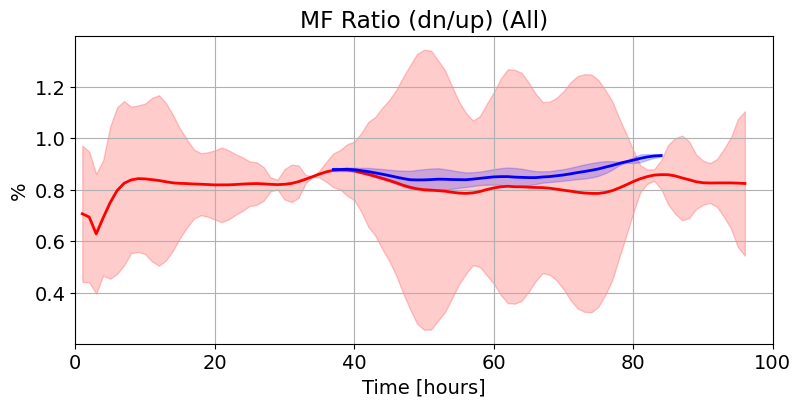

deep


/scratch/jamesrup/tmp/ipykernel_20100/964362313.py:62: FutureWarning: Support for axis=1 in DataFrame.rolling is deprecated and will be removed in a future version. Use obj.T.rolling(...) instead
  var0 = var0.rolling(window=3, center=True, closed='both', axis=1).mean()
/scratch/jamesrup/tmp/ipykernel_20100/964362313.py:64: FutureWarning: Support for axis=1 in DataFrame.rolling is deprecated and will be removed in a future version. Use obj.T.rolling(...) instead
  var1 = var1.rolling(window=3, center=True, closed='both', axis=1).mean()
/scratch/jamesrup/tmp/ipykernel_20100/964362313.py:96: RuntimeWarning: Mean of empty slice
  mean_t0 = np.nanmean(var0, axis=0)
/home/jamesrup/.conda/envs/plotting/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/scratch/jamesrup/tmp/ipykernel_20100/964362313.py:109: RuntimeWarning: Mean of empty slice
  mean_t1 = np.nanmean(var1,

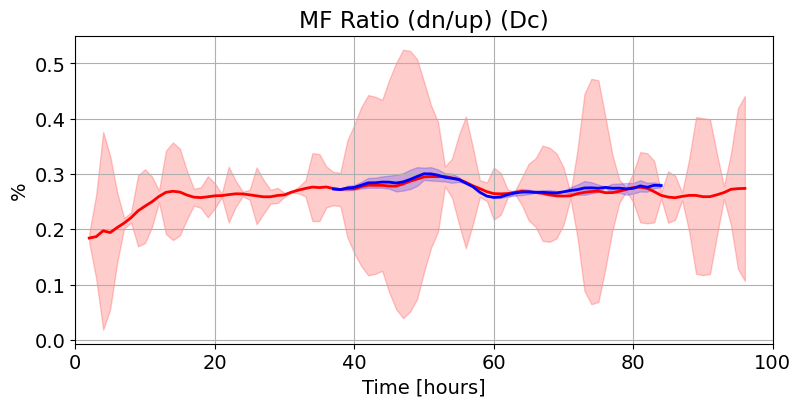

deepcong


/scratch/jamesrup/tmp/ipykernel_20100/964362313.py:62: FutureWarning: Support for axis=1 in DataFrame.rolling is deprecated and will be removed in a future version. Use obj.T.rolling(...) instead
  var0 = var0.rolling(window=3, center=True, closed='both', axis=1).mean()
/scratch/jamesrup/tmp/ipykernel_20100/964362313.py:64: FutureWarning: Support for axis=1 in DataFrame.rolling is deprecated and will be removed in a future version. Use obj.T.rolling(...) instead
  var1 = var1.rolling(window=3, center=True, closed='both', axis=1).mean()
/scratch/jamesrup/tmp/ipykernel_20100/964362313.py:96: RuntimeWarning: Mean of empty slice
  mean_t0 = np.nanmean(var0, axis=0)
/home/jamesrup/.conda/envs/plotting/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/scratch/jamesrup/tmp/ipykernel_20100/964362313.py:109: RuntimeWarning: Mean of empty slice
  mean_t1 = np.nanmean(var1,

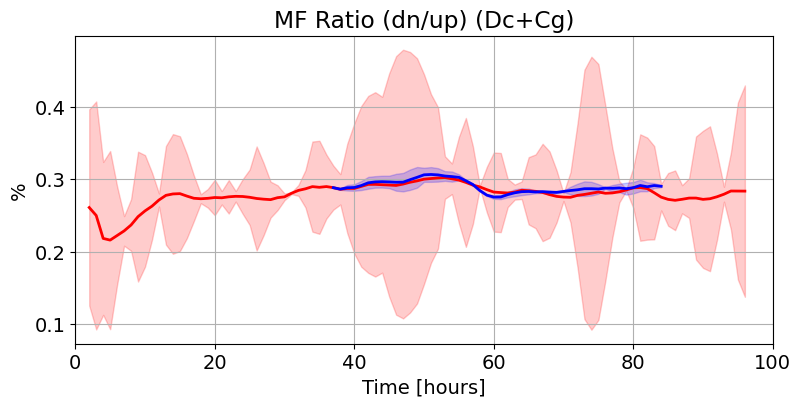

stratanv


/scratch/jamesrup/tmp/ipykernel_20100/964362313.py:62: FutureWarning: Support for axis=1 in DataFrame.rolling is deprecated and will be removed in a future version. Use obj.T.rolling(...) instead
  var0 = var0.rolling(window=3, center=True, closed='both', axis=1).mean()
/scratch/jamesrup/tmp/ipykernel_20100/964362313.py:64: FutureWarning: Support for axis=1 in DataFrame.rolling is deprecated and will be removed in a future version. Use obj.T.rolling(...) instead
  var1 = var1.rolling(window=3, center=True, closed='both', axis=1).mean()
/scratch/jamesrup/tmp/ipykernel_20100/964362313.py:96: RuntimeWarning: Mean of empty slice
  mean_t0 = np.nanmean(var0, axis=0)
/home/jamesrup/.conda/envs/plotting/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/scratch/jamesrup/tmp/ipykernel_20100/964362313.py:109: RuntimeWarning: Mean of empty slice
  mean_t1 = np.nanmean(var1,

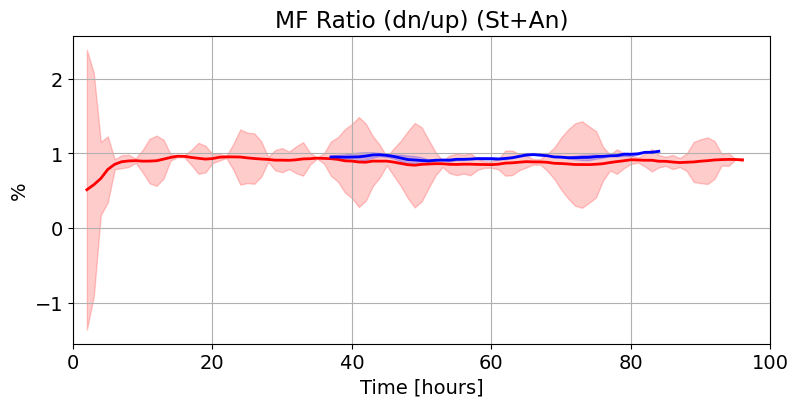

allrain


/scratch/jamesrup/tmp/ipykernel_20100/964362313.py:62: FutureWarning: Support for axis=1 in DataFrame.rolling is deprecated and will be removed in a future version. Use obj.T.rolling(...) instead
  var0 = var0.rolling(window=3, center=True, closed='both', axis=1).mean()
/scratch/jamesrup/tmp/ipykernel_20100/964362313.py:64: FutureWarning: Support for axis=1 in DataFrame.rolling is deprecated and will be removed in a future version. Use obj.T.rolling(...) instead
  var1 = var1.rolling(window=3, center=True, closed='both', axis=1).mean()
/scratch/jamesrup/tmp/ipykernel_20100/964362313.py:96: RuntimeWarning: Mean of empty slice
  mean_t0 = np.nanmean(var0, axis=0)
/home/jamesrup/.conda/envs/plotting/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/scratch/jamesrup/tmp/ipykernel_20100/964362313.py:109: RuntimeWarning: Mean of empty slice
  mean_t1 = np.nanmean(var1,

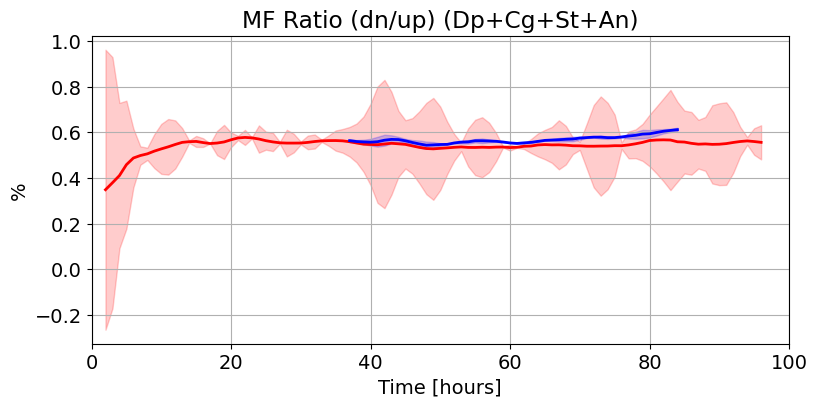

upward
downward
pe_mf
all


/scratch/jamesrup/tmp/ipykernel_20100/964362313.py:62: FutureWarning: Support for axis=1 in DataFrame.rolling is deprecated and will be removed in a future version. Use obj.T.rolling(...) instead
  var0 = var0.rolling(window=3, center=True, closed='both', axis=1).mean()
/scratch/jamesrup/tmp/ipykernel_20100/964362313.py:64: FutureWarning: Support for axis=1 in DataFrame.rolling is deprecated and will be removed in a future version. Use obj.T.rolling(...) instead
  var1 = var1.rolling(window=3, center=True, closed='both', axis=1).mean()
/scratch/jamesrup/tmp/ipykernel_20100/964362313.py:96: RuntimeWarning: Mean of empty slice
  mean_t0 = np.nanmean(var0, axis=0)
/home/jamesrup/.conda/envs/plotting/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/scratch/jamesrup/tmp/ipykernel_20100/964362313.py:109: RuntimeWarning: Mean of empty slice
  mean_t1 = np.nanmean(var1,

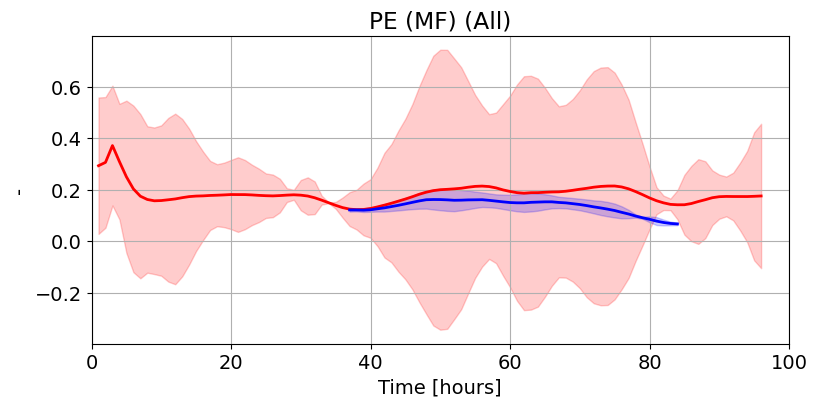

deep


/scratch/jamesrup/tmp/ipykernel_20100/964362313.py:62: FutureWarning: Support for axis=1 in DataFrame.rolling is deprecated and will be removed in a future version. Use obj.T.rolling(...) instead
  var0 = var0.rolling(window=3, center=True, closed='both', axis=1).mean()
/scratch/jamesrup/tmp/ipykernel_20100/964362313.py:64: FutureWarning: Support for axis=1 in DataFrame.rolling is deprecated and will be removed in a future version. Use obj.T.rolling(...) instead
  var1 = var1.rolling(window=3, center=True, closed='both', axis=1).mean()
/scratch/jamesrup/tmp/ipykernel_20100/964362313.py:96: RuntimeWarning: Mean of empty slice
  mean_t0 = np.nanmean(var0, axis=0)
/home/jamesrup/.conda/envs/plotting/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/scratch/jamesrup/tmp/ipykernel_20100/964362313.py:109: RuntimeWarning: Mean of empty slice
  mean_t1 = np.nanmean(var1,

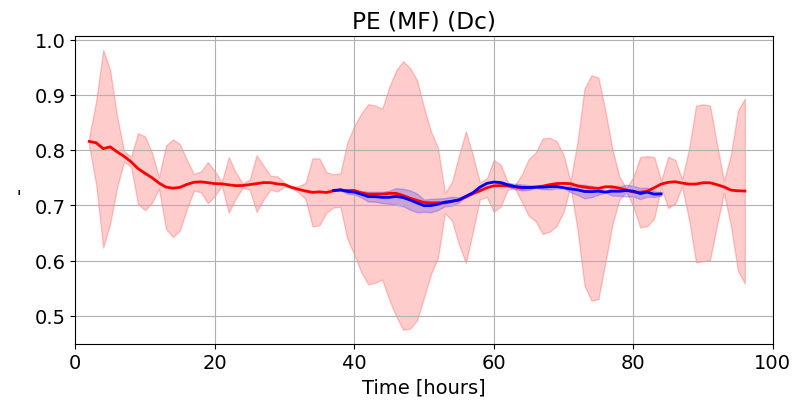

deepcong


/scratch/jamesrup/tmp/ipykernel_20100/964362313.py:62: FutureWarning: Support for axis=1 in DataFrame.rolling is deprecated and will be removed in a future version. Use obj.T.rolling(...) instead
  var0 = var0.rolling(window=3, center=True, closed='both', axis=1).mean()
/scratch/jamesrup/tmp/ipykernel_20100/964362313.py:64: FutureWarning: Support for axis=1 in DataFrame.rolling is deprecated and will be removed in a future version. Use obj.T.rolling(...) instead
  var1 = var1.rolling(window=3, center=True, closed='both', axis=1).mean()
/scratch/jamesrup/tmp/ipykernel_20100/964362313.py:96: RuntimeWarning: Mean of empty slice
  mean_t0 = np.nanmean(var0, axis=0)
/home/jamesrup/.conda/envs/plotting/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/scratch/jamesrup/tmp/ipykernel_20100/964362313.py:109: RuntimeWarning: Mean of empty slice
  mean_t1 = np.nanmean(var1,

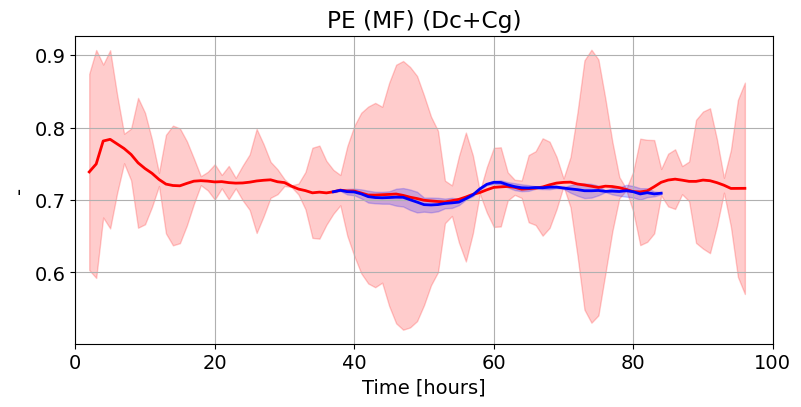

stratanv


/scratch/jamesrup/tmp/ipykernel_20100/964362313.py:62: FutureWarning: Support for axis=1 in DataFrame.rolling is deprecated and will be removed in a future version. Use obj.T.rolling(...) instead
  var0 = var0.rolling(window=3, center=True, closed='both', axis=1).mean()
/scratch/jamesrup/tmp/ipykernel_20100/964362313.py:64: FutureWarning: Support for axis=1 in DataFrame.rolling is deprecated and will be removed in a future version. Use obj.T.rolling(...) instead
  var1 = var1.rolling(window=3, center=True, closed='both', axis=1).mean()
/scratch/jamesrup/tmp/ipykernel_20100/964362313.py:96: RuntimeWarning: Mean of empty slice
  mean_t0 = np.nanmean(var0, axis=0)
/home/jamesrup/.conda/envs/plotting/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/scratch/jamesrup/tmp/ipykernel_20100/964362313.py:109: RuntimeWarning: Mean of empty slice
  mean_t1 = np.nanmean(var1,

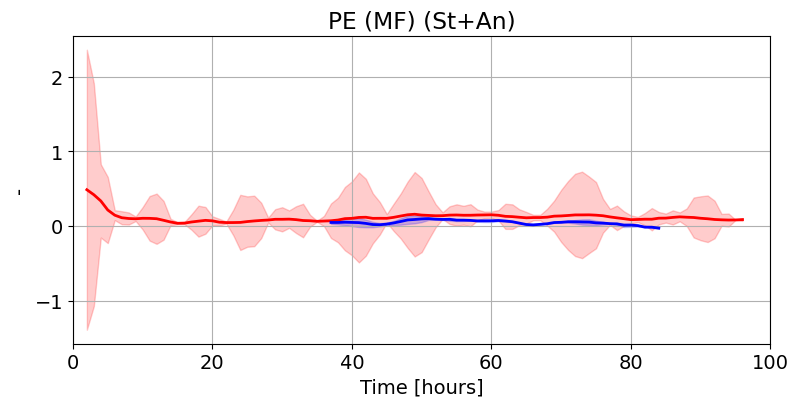

allrain


/scratch/jamesrup/tmp/ipykernel_20100/964362313.py:62: FutureWarning: Support for axis=1 in DataFrame.rolling is deprecated and will be removed in a future version. Use obj.T.rolling(...) instead
  var0 = var0.rolling(window=3, center=True, closed='both', axis=1).mean()
/scratch/jamesrup/tmp/ipykernel_20100/964362313.py:64: FutureWarning: Support for axis=1 in DataFrame.rolling is deprecated and will be removed in a future version. Use obj.T.rolling(...) instead
  var1 = var1.rolling(window=3, center=True, closed='both', axis=1).mean()
/scratch/jamesrup/tmp/ipykernel_20100/964362313.py:96: RuntimeWarning: Mean of empty slice
  mean_t0 = np.nanmean(var0, axis=0)
/home/jamesrup/.conda/envs/plotting/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/scratch/jamesrup/tmp/ipykernel_20100/964362313.py:109: RuntimeWarning: Mean of empty slice
  mean_t1 = np.nanmean(var1,

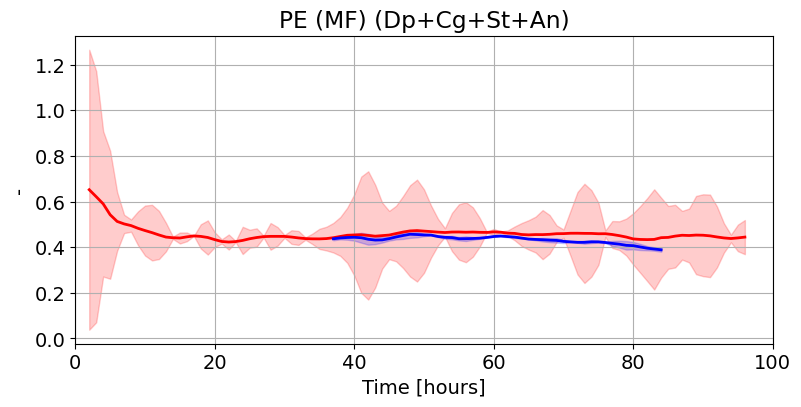

upward
downward


In [45]:
font = {'family' : 'sans-serif',
        'weight' : 'normal',
        'size'   : 14}

matplotlib.rc('font', **font)

# var_filled = np.ma.filled(var_sav_plot, fill_value=np.nan)
# Don't need this anymore since already NaN-filled

for ivar in range(nvars_plot):
# for ivar in range(1,2):

    var0_ivar = var_sav_plot[0, :, :, ivar, :]
    var1_ivar = var_sav_plot[1, :, :, ivar, :]

    figtag = var_names_plot[ivar]
    print(figtag)

    for icond in range(ncond):
    # for krain in range(1):

        fig_extra=condavg_label[icond]
        condtag=condavg_title[icond]
        print(fig_extra)

        var0 = np.copy(var0_ivar[:, icond, :])
        var1 = np.copy(var1_ivar[:, icond, :])

        if figtag == 'mf_ratio':
            title_tag = 'MF Ratio (dn/up)'
            ylabel = '%'
            if (condavg_label[icond] == 'upward') or (condavg_label[icond] == 'downward'):
                continue
        elif figtag == 'pe_mf':
            title_tag = 'PE (MF)'
            ylabel = '-'
            if (condavg_label[icond] == 'upward') or (condavg_label[icond] == 'downward'):
                continue
        elif figtag == 'pw':
            title_tag = 'WVP'
            ylabel = 'mm'
        elif figtag == 'mse_vint':
            title_tag = '$<h>$'
            ylabel = 'J/m$^2$'
        elif figtag == 'vadv_mse_vint':
            title_tag = 'VADV($h$) (Eul.)'
            ylabel = 'J/m$^2$/s'
        elif figtag == 'mse_diverg_vint':
            title_tag = '-$h$(Del.$V$)'
            ylabel = 'J/m$^2$/s'
        elif figtag == 'mse_fluxdiverg_vint':
            title_tag = '-Del.($hV$)'
            ylabel = 'J/m$^2$/s'
        elif figtag == 'satfrac':
            title_tag = 'Saturation Fraction'
            ylabel = '%'

    #----------------------------------------------------------------

        # Use Pandas to smooth via running mean
        var0 = pd.DataFrame(var0)
        var0 = var0.rolling(window=3, center=True, closed='both', axis=1).mean()
        var1 = pd.DataFrame(var1)
        var1 = var1.rolling(window=3, center=True, closed='both', axis=1).mean()

        # create figure
        fig = plt.figure(figsize=(9,4))
        ax = fig.add_subplot(111)

        # ax.set_title(title_tag+' ('+storm.capitalize()+'; '+raintag+')')#, fontsize=20)
        ax.set_title(title_tag+' ('+condtag+')')#, fontsize=20)
        ax.set_ylabel(ylabel)
        ax.set_xlabel('Time [hours]')

        # if (ivar == 0):
        #     plt.ylim([-1,1])
        #     # if (krain ==2):
        #     #     plt.ylim([-1.5,-.5])
        #     # else:
        #     #     plt.ylim([-.5,.5])
        # if (ivar == 5):
        #     if (kplot == 2): plt.ylim([-50,50])

        # t_range=[30,80]
        t_range=[0,100]
        # if storm == 'maria':
        #     t_range=[40,90]

        plt.xlim(t_range)

        color_t0 = 'red'
        color_t1 = 'blue'

        # Test 0

        mean_t0 = np.nanmean(var0, axis=0)
        std_t0 = np.nanstd(var0, axis=0)
        mean, low, high = mean_confidence_interval(var0)

        xdim = range(nt[0])

        # plt.plot(xdim, mean_t0, linewidth=2, label=tests[0].upper(), color=color_t0, linestyle='solid')
        # plt.fill_between(xdim, mean_t0 + std_t0, mean_t0 - std_t0, alpha=0.2, color=color_t0)
        plt.plot(xdim, mean, linewidth=2, label=tests[0].upper(), color=color_t0, linestyle='solid')
        plt.fill_between(xdim, high, low, alpha=0.2, color=color_t0)

        # Test 1

        mean_t1 = np.nanmean(var1, axis=0)
        std_t1 = np.nanstd(var1, axis=0)
        mean, low, high = mean_confidence_interval(var1)

        plt.plot(xdim, mean_t1, linewidth=2, label=tests[0].upper(), color=color_t1, linestyle='solid')
        plt.fill_between(xdim, mean_t1 + std_t1, mean_t1 - std_t1, alpha=0.2, color=color_t1)
        # plt.plot(xdim, mean, linewidth=2, label=tests[0].upper(), color=color_t1, linestyle='solid')
        # plt.fill_between(xdim, high, low, alpha=0.2, color=color_t1)

        plt.grid()

        # plt.legend(loc="upper right")

        figdir2 = figdir+'all/'
        # figname=figdir2+'tser_'+storm+'_'+figtag+'_'+fig_extra+'_rmax'+rmax_str+'deg.png'
        figname=figdir2+'tser_'+storm+'_'+figtag+'_'+fig_extra+'.png'
        plt.savefig(figname,dpi=200, facecolor='white', \
                    bbox_inches='tight', pad_inches=0.2)
        plt.show()
        plt.close()